# VLMs guessing image segmentation strategies

In this notebook we present images to VLMs and ask them which algorithm to use for segmenting the image. One could expect that depending on the image, the VLM suggests different strategies. In a second example, we demonstrate how a list of rules can be used to guide the VLM in guiding us.

In [1]:
import openai
import PIL
import stackview
from skimage import data
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

We will need some helper functions for assembling a prompt and submitting it to the openai server.

In [2]:
def prompt_with_image(message:str, image=None, model="gpt-4o-2024-11-20"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    # convert message in the right format if necessary
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
    
    if image is not None:
        image_message = image_to_message(image)
    else:
        image_message = []
        
    # setup connection to the LLM
    client = openai.OpenAI()
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message + image_message
    )
    
    # extract answer
    return response.choices[0].message.content


def image_to_message(image):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

These are the example images we will be using.

[[4496 5212 6863 ... 2917 2680 2642]
 [4533 5146 7555 ... 2843 2857 2748]
 [4640 6082 8452 ... 3372 3039 3128]
 ...
 [1339 1403 1359 ... 4458 4314 4795]
 [1473 1560 1622 ... 3967 4531 4204]
 [1380 1368 1649 ... 3091 3558 3682]]
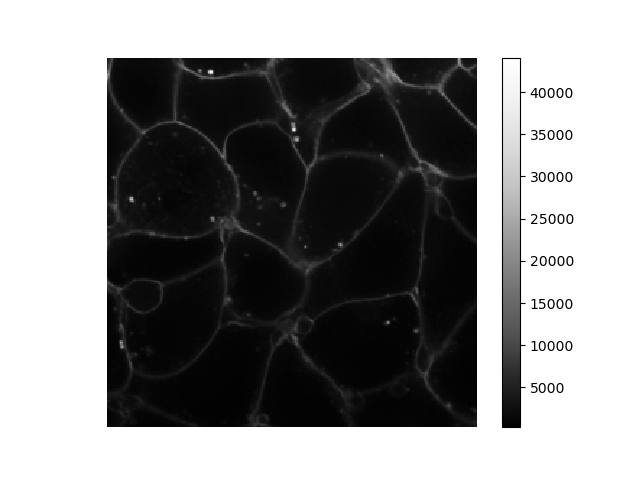
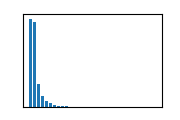

In [3]:
membrane_image = data.cells3d()[30, 0]
stackview.insight(membrane_image)

[[ 8  8  8 ... 10 11 10]
 [ 8  8  8 ... 11 12 11]
 [ 9  8  7 ... 13 14 14]
 ...
 [ 8  8  8 ...  9  9  9]
 [ 8  8  8 ...  9  8  9]
 [ 9  8  8 ...  9  9  9]]
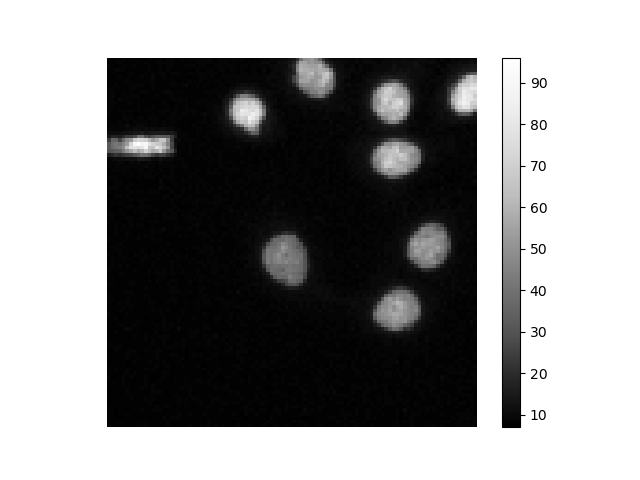
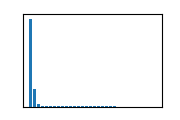

In [4]:
nuclei_image = data.human_mitosis()[100:200,:100]
stackview.insight(nuclei_image)

[[14 14 13 ... 15 12 11]
 [17 15 14 ... 16 14 13]
 [22 15 13 ... 16 13 13]
 ...
 [14 14 21 ... 13 13 14]
 [12 12 14 ... 13 14 14]
 [12 11 12 ... 13 14 13]]
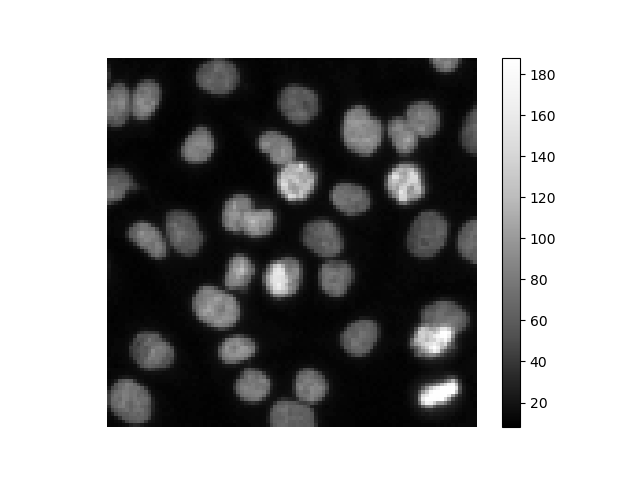
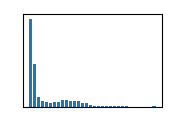

In [5]:
dense_nuclei_image = data.human_mitosis()[330:430, 355:455]
stackview.insight(dense_nuclei_image)

[[[ 3  6  1]
  [ 3  7  0]
  [ 3  6  1]
  ...
  [11  8  2]
  [11  7  2]
  [11 11  2]]

 [[ 3  6  1]
  [ 3  8  1]
  [ 3  7  1]
  ...
  [11 10  2]
  [10 10  2]
  [11 11  2]]

 [[ 4  6  1]
  [ 3  6  1]
  [ 4  6  1]
  ...
  [10 10  2]
  [11 10  2]
  [11 10  2]]

 ...

 [[15 14  8]
  [14 14  8]
  [15 14  7]
  ...
  [10 11  5]
  [10 12  4]
  [11 14  5]]

 [[14 16  7]
  [16 15  7]
  [15 16  8]
  ...
  [10 11  4]
  [11 13  4]
  [11 16  5]]

 [[15 18  7]
  [14 17  8]
  [14 17  8]
  ...
  [ 9 12  5]
  [10 13  5]
  [11 15  5]]]
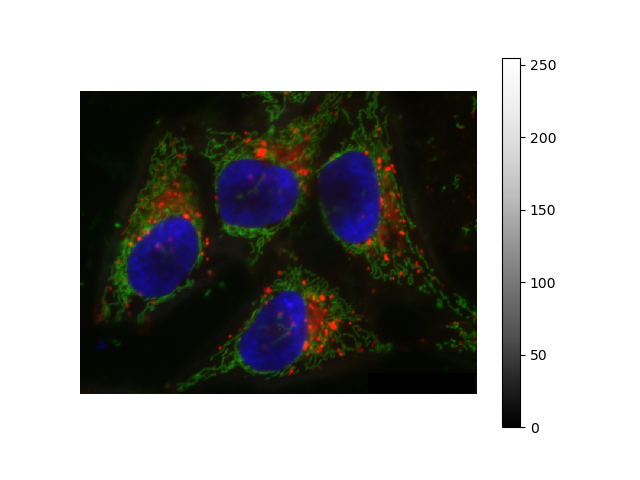
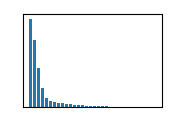

In [6]:
hela_cells = imread("data/hela-cells-8bit.tif")
stackview.insight(hela_cells)

This helper function will send the image together with a prompt to the LLM service provider and display a word cloud of the suggested algorithms.

In [7]:
def determine_algorithm(prompt, image, num_samples=25):
    responses = []
    for _ in range(num_samples):
        responses.append(prompt_with_image(prompt, image))
    text = "\n".join(responses)

    # Generate word cloud
    w = wordcloud.WordCloud(width=800, height=400, colormap='viridis', background_color='white').generate(text)

    # Display the word cloud
    plt.imshow(w, interpolation='bilinear')
    plt.show()

This is the simple prompt we submit to the server.

In [8]:
prompt = """You are a bioimage-analysis expert.
What is the best image processing algorithm to segment this microscopy image?
Answer the algorithm name only. No explanations.
"""

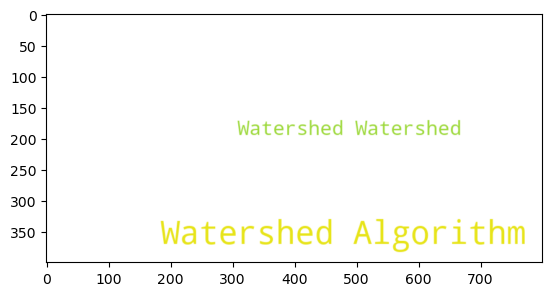

In [9]:
determine_algorithm(prompt, membrane_image)

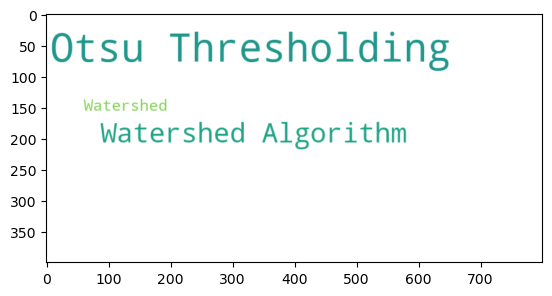

In [10]:
determine_algorithm(prompt, nuclei_image)

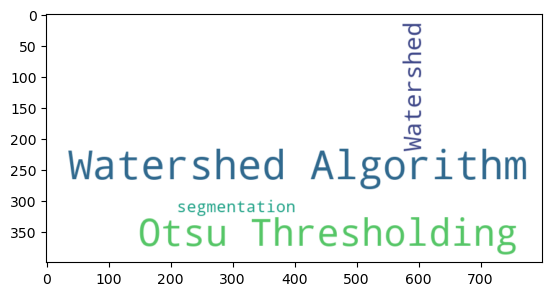

In [11]:
determine_algorithm(prompt, dense_nuclei_image)

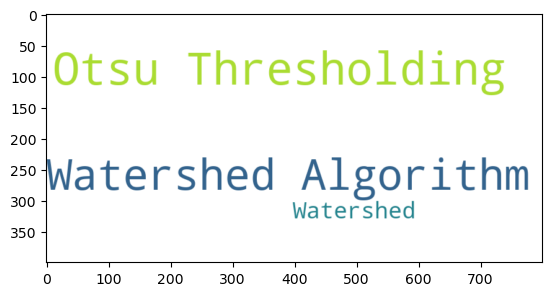

In [12]:
determine_algorithm(prompt, hela_cells)

Next, we try the same strategy using a more complex prompt containing a list of rules to guide the VLM.

In [13]:
prompt = """You are a bioimage-analysis expert. You have a rule-book what alogrithms to use for specific images.

## Rules

* If an image shows sparse objects such as nuclei, use Otsu-thresholding for segmenting them.
* If an image shows dense, partially overlapping objects such as nuclei, use StarDist.
* If an image shows large cell-like structures with bright membranes, use the Watershed algorithm.
* In case of doubt, use CellPose.

## The task

What is the best image processing algorithm to segment this microscopy image?
Answer the algorithm name only. No explanations.
"""

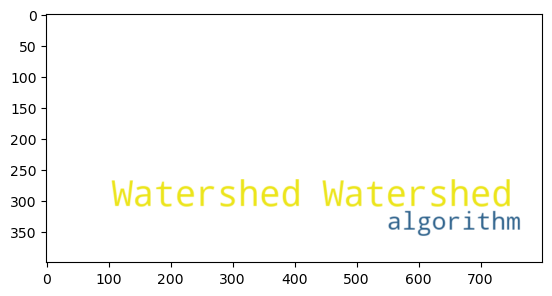

In [14]:
determine_algorithm(prompt, membrane_image)

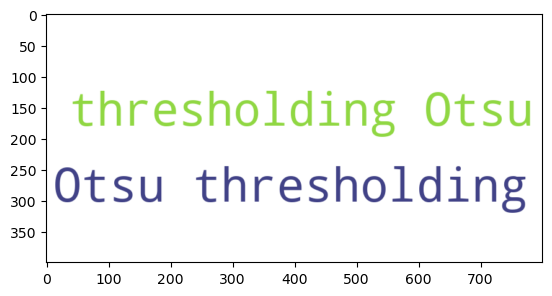

In [15]:
determine_algorithm(prompt, nuclei_image)

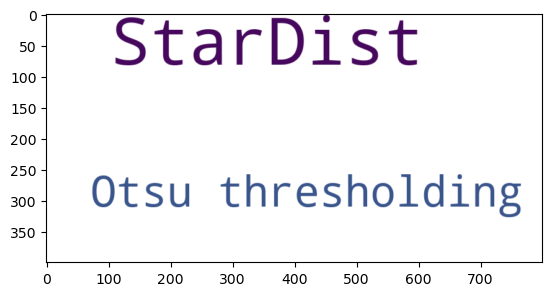

In [16]:
determine_algorithm(prompt, dense_nuclei_image)

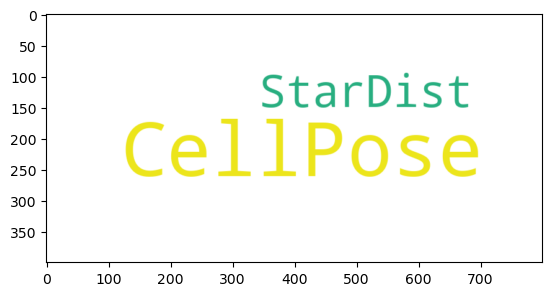

In [17]:
determine_algorithm(prompt, hela_cells)

## Exercise
Load a natural picture, e.g. showing of a cat, and ask the LLM how to process the image using both prompts above.